<a href="https://colab.research.google.com/github/rafaelMartins1922/kaggle-fraud-detection-challenge/blob/main/iee_cis_fraud_detection_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, Binarizer, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, plot_roc_curve
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train_transaction = pd.read_csv("/content/drive/MyDrive/teste/train_transaction.csv")
test_transaction = pd.read_csv("/content/drive/MyDrive/teste/test_transaction.csv")

train_identity = pd.read_csv("/content/drive/MyDrive/teste/train_identity.csv")
test_identity = pd.read_csv("/content/drive/MyDrive/teste/test_identity.csv")

train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction,test_identity, on = 'TransactionID', how = 'left')

In [ ]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('train:',train.shape)
print('test:', test.shape)

train: (590540, 434)
test: (506691, 433)


In [ ]:
# Data Transformation
## dropping nulls
# train.dropna(thresh=train.shape[0]*0.5,how='all',axis=1, inplace=True)



In [ ]:
# Data Transformation

## dropping unecessary columns
train = train[['ProductCD', 'DeviceType', 'card4', 'card6', 'R_emaildomain', 'id_02', 'id_16', 'id_35', 'id_38', 'V10', 'V12', 'V13', 'V15', 'V17', 'V18', 'V24', 'V31','isFraud']]
test = test[['ProductCD', 'DeviceType', 'card4', 'card6', 'R_emaildomain', 'id-02', 'id-16', 'id-35', 'id-38', 'V10', 'V12', 'V13', 'V15', 'V17', 'V18', 'V24', 'V31']]

continuous = train.select_dtypes(include=[np.number]).columns # all continuous columns
categorical = train.select_dtypes(exclude=[np.number]).columns
## filling nulls
train = train.fillna(train.mode().iloc[0])

## normalization, standardization 
train[continuous] = (train[continuous]-train[continuous].mean())/train[continuous].std() 
train[continuous] = (train[continuous]-train[continuous].min())/(train[continuous].max()-train[continuous].min())

In [ ]:
train.isna().sum()

In [ ]:
# Makes predictions and prints metrics used to evaluate each model
def evaluate_supervised_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    ra_score = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('Acurácia: ', accuracy)
    print('Precisão: ', precision)
    print('Recall: ', recall)
    print('ROC AUC Score: ', ra_score)
    print('F1: ', f1)
    
    return {'Acurácia':accuracy, 'Precisão':precision, 'Recall': recall, 'F1':f1}

In [ ]:
# Supervised learning - Decision Tree Classifier
features = ['ProductCD', 'DeviceType', 'card4', 'card6', 'R_emaildomain', 'id_02', 'id_16', 'id_35', 'id_38', 'V10', 'V12', 'V13', 'V15', 'V17', 'V18', 'V24', 'V31']
target = 'isFraud'
#Data split - No sampling
X = train[features]
y = train[target]

decision_tree_results = pd.DataFrame()

print('\nDecision Tree Classifier - No resampling')
dtc = DecisionTreeClassifier()
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

new_results = evaluate_supervised_model(dtc, X_train, X_test, y_train, y_test, 'Decision Tree Classifier')
decision_tree_results = decision_tree_results.append(new_results, ignore_index=True)

print(decision_tree_results)

print('\nDecision Tree Classifier - Undersampling')
dtc = DecisionTreeClassifier()
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X,y)
X_rus = pd.get_dummies(X_rus)
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.20)
new_results = evaluate_supervised_model(dtc, X_train_rus, X_test_rus, y_train_rus, y_test_rus, 'Decision Tree Classifier')
decision_tree_results = decision_tree_results.append(new_results, ignore_index=True)

print('\nDecision Tree Classifier - Oversampling')
dtc = DecisionTreeClassifier()

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X,y)
X_ros = pd.get_dummies(X_ros)

X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.20)

new_results = evaluate_supervised_model(dtc, X_train_ros, X_test_ros, y_train_ros, y_test_ros, 'Decision Tree Classifier')
decision_tree_results = decision_tree_results.append(new_results, ignore_index=True)

print(decision_tree_results)


Decision Tree Classifier - No resampling
Acurácia:  0.9568361160971315
Precisão:  0.2942404006677796
Recall:  0.17144941634241245
ROC AUC Score:  0.5783077812614901
F1:  0.21665642286416717
   Acurácia  Precisão    Recall        F1
0  0.956836   0.29424  0.171449  0.216656

Decision Tree Classifier - Undersampling
Acurácia:  0.6959835470602468
Precisão:  0.7531013615733737
Recall:  0.5946010511227903
ROC AUC Score:  0.6973005255613952
F1:  0.6645307702576425

Decision Tree Classifier - Oversampling
Acurácia:  0.806037262394111
Precisão:  0.8806779292737248
Recall:  0.7092472854855503
ROC AUC Score:  0.8063076421092957
F1:  0.7857205168219135
   Acurácia  Precisão    Recall        F1
0  0.956836  0.294240  0.171449  0.216656
1  0.695984  0.753101  0.594601  0.664531
2  0.806037  0.880678  0.709247  0.785721


In [ ]:
# Supervised learning - Random Forest Classifier
random_forest_results = pd.DataFrame()

print('\nRandom Forest Classifier - No resampling')

rfc = RandomForestClassifier()
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

new_results = evaluate_supervised_model(rfc, X_train, X_test, y_train, y_test, 'Random Forest Classifier')
random_forest_results = random_forest_results.append(new_results, ignore_index=True)

print(random_forest_results)

print('\nRandom Forest Classifier - Undersampling')
rfc = RandomForestClassifier()

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X,y)
X_rus = pd.get_dummies(X_rus)
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.20)

new_results = evaluate_supervised_model(rfc, X_train_rus, X_test_rus, y_train_rus, y_test_rus, 'Random Forest Classifier')
random_forest_results = random_forest_results.append(new_results, ignore_index=True)

print('\nRandom Forest Classifier - Oversampling')
rfc = RandomForestClassifier()

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X,y)
X_ros = pd.get_dummies(X_ros)
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.20)

new_results = evaluate_supervised_model(rfc, X_train_ros, X_test_ros, y_train_ros, y_test_ros, 'Random Forest Classifier')
random_forest_results = random_forest_results.append(new_results, ignore_index=True)

print(random_forest_results)


Random Forest Classifier - No resampling
Acurácia:  0.9581484742777796
Precisão:  0.32038834951456313
Recall:  0.17582949866795836
ROC AUC Score:  0.5811591189108309
F1:  0.2270523846755278
   Acurácia  Precisão    Recall        F1
0  0.958148  0.320388  0.175829  0.227052

Random Forest Classifier - Undersampling
Acurácia:  0.7042100169368497
Precisão:  0.7479166666666667
Recall:  0.6112867915349064
ROC AUC Score:  0.703718004672387
F1:  0.672734573684915

Random Forest Classifier - Oversampling
Acurácia:  0.8050370474356331
Precisão:  0.8870048909333065
Recall:  0.6976557892234967
ROC AUC Score:  0.8046834983615735
F1:  0.7810177976624554
   Acurácia  Precisão    Recall        F1
0  0.958148  0.320388  0.175829  0.227052
1  0.704210  0.747917  0.611287  0.672735
2  0.805037  0.887005  0.697656  0.781018


In [ ]:
KMean= KMeans(n_clusters=2)

kmeans_results = pd.DataFrame()
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

KMean.fit(X_train)
label=KMean.predict(X_test)

s_score = silhouette_score(X_test, label)
print(f'Silhouette Score(n=2): {silhouette_score}')

ch_score = calinski_harabasz_score(X_test, label)
print(f'Calinski-Harabasz score(n=2): {ch_score}')

new_results = {'Sillhuette Score': s_score, 'Calinski-Harabasz Score': ch_score}
kmeans_results = kmeans_results.append(new_results, ignore_index=True)

print(kmeans_results, new_results)

KMean= KMeans(n_clusters=2)

rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X,y)
X_rus = pd.get_dummies(X_rus)
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.20)

KMean.fit(X_train_rus)
label=KMean.predict(X_test_rus)

s_score = silhouette_score(X_test_rus, label)
print(f'Silhouette Score(n=2): {silhouette_score}')

ch_score = calinski_harabasz_score(X_test_rus, label)
print(f'Calinski-Harabasz score(n=2): {ch_score}')

new_results = {'Sillhuette Score': s_score, 'Calinski-Harabasz Score': ch_score}
kmeans_results = kmeans_results.append(new_results, ignore_index=True)
print(kmeans_results)

KMean= KMeans(n_clusters=2)
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X,y)
X_ros = pd.get_dummies(X_ros)
X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.20)

KMean.fit(X_train_ros)
label=KMean.predict(X_test_ros)

s_score = silhouette_score(X_test_ros, label)
print(f'Silhouette Score(n=2): {silhouette_score}')

ch_score = calinski_harabasz_score(X_test_ros, label)
print(f'Calinski-Harabasz score(n=2): {ch_score}')

new_results = {'Sillhuette Score': s_score, 'Calinski-Harabasz Score': ch_score}
kmeans_results = kmeans_results.append(new_results, ignore_index=True)
print(kmeans_results)

Silhouette Score(n=2): <function silhouette_score at 0x7fb66f747c10>
Calinski-Harabasz score(n=2): 44354.03964451457
   Sillhuette Score  Calinski-Harabasz Score
0          0.478552             44354.039645 {'Sillhuette Score': 0.4785516241122966, 'Calinski-Harabasz Score': 44354.03964451457}
Silhouette Score(n=2): <function silhouette_score at 0x7fb66f747c10>
Calinski-Harabasz score(n=2): 3274.6568647822487
   Sillhuette Score  Calinski-Harabasz Score
0          0.478552             44354.039645
1          0.384227              3274.656865
Silhouette Score(n=2): <function silhouette_score at 0x7fb66f747c10>
Calinski-Harabasz score(n=2): 91124.73189422779
   Sillhuette Score  Calinski-Harabasz Score
0          0.478552             44354.039645
1          0.384227              3274.656865
2          0.386042             91124.731894


In [ ]:
print(decision_tree_results)
print(random_forest_results)
print(kmeans_results)

   Acurácia  Precisão    Recall        F1
0  0.956836  0.294240  0.171449  0.216656
1  0.695984  0.753101  0.594601  0.664531
2  0.806037  0.880678  0.709247  0.785721
   Acurácia  Precisão    Recall        F1
0  0.958148  0.320388  0.175829  0.227052
1  0.704210  0.747917  0.611287  0.672735
2  0.805037  0.887005  0.697656  0.781018
   Sillhuette Score  Calinski-Harabasz Score
0          0.478552             44354.039645
1          0.384227              3274.656865
2          0.386042             91124.731894


['Acurácia', 'Precisão', 'Recall', 'F1']


<Figure size 720x288 with 0 Axes>

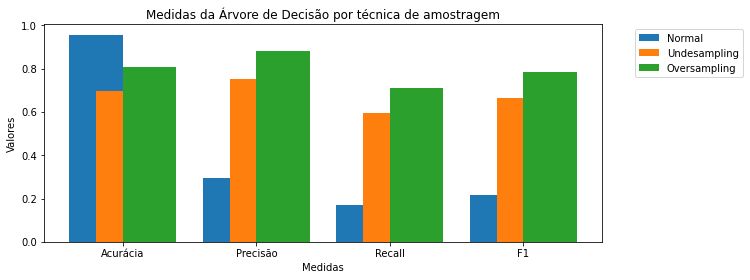

In [ ]:
plot_X = list(decision_tree_results.columns)
print(plot_X)

X_axis = np.arange(len(plot_X))
plt.figure().set_figwidth(10)


plt.figure().set_figwidth(10)
plt.bar(X_axis - 0.2, decision_tree_results.iloc[0], 0.4, label= 'Normal')
plt.bar(X_axis, decision_tree_results.iloc[1] , 0.4, label= 'Undesampling')
plt.bar(X_axis+0.2, decision_tree_results.iloc[2] , 0.4, label= 'Oversampling')

plt.xticks(X_axis, plot_X)
plt.xlabel('Medidas')
plt.ylabel(f'Valores')
plt.title(f'Medidas da Árvore de Decisão por técnica de amostragem')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

['Acurácia', 'Precisão', 'Recall', 'F1']


<Figure size 720x288 with 0 Axes>

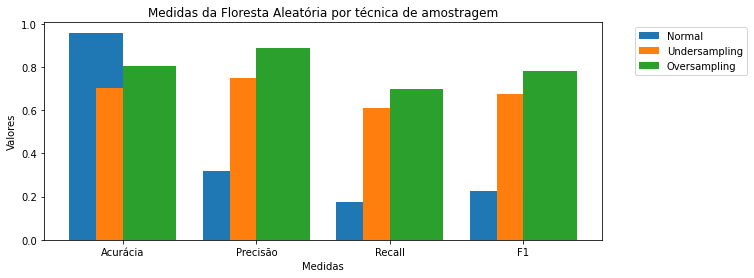

In [ ]:
plot_X = list(random_forest_results.columns)
print(plot_X)

X_axis = np.arange(len(plot_X))
plt.figure().set_figwidth(10)


plt.figure().set_figwidth(10)
plt.bar(X_axis - 0.2, random_forest_results.iloc[0], 0.4, label= 'Normal')
plt.bar(X_axis, random_forest_results.iloc[1] , 0.4, label= 'Undersampling')
plt.bar(X_axis+0.2, random_forest_results.iloc[2] , 0.4, label= 'Oversampling')

plt.xticks(X_axis, plot_X)
plt.xlabel('Medidas')
plt.ylabel(f'Valores')
plt.title(f'Medidas da Floresta Aleatória por técnica de amostragem')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

[0.4785516241122966, 0.38422656073853717, 0.38604188831678254]


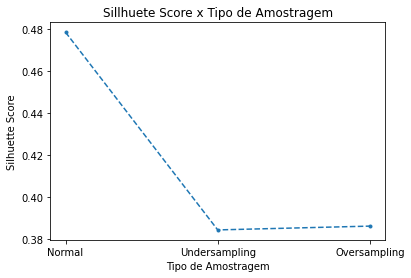

[44354.03964451457, 3274.6568647822487, 91124.73189422779]


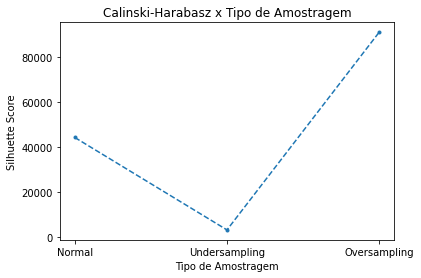

In [ ]:
x_axis = ['Normal' ,'Undersampling', 'Oversampling']
y_axis = list(kmeans_results['Sillhuette Score'])
print(y_axis)

plt.plot(x_axis, y_axis, marker='.', linestyle='dashed')
plt.title('Sillhuete Score x Tipo de Amostragem')
plt.xlabel('Tipo de Amostragem')
plt.ylabel('Silhuette Score')
plt.show()

x_axis = ['Normal' ,'Undersampling', 'Oversampling']
y_axis = list(kmeans_results['Calinski-Harabasz Score'])
print(y_axis)

plt.plot(x_axis, y_axis, marker='.', linestyle='dashed')
plt.title('Calinski-Harabasz x Tipo de Amostragem')
plt.xlabel('Tipo de Amostragem')
plt.ylabel('Silhuette Score')
plt.show()